In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import g
from IPython import display

3.2: 2D Löser und ein Verfahren zweiter Ordnung 

In [41]:
# Reflektierender Rand um einen Block:
def reflektierender_block(Nx, Ny, h):
    # EDGES
    for j in range(Nx):
        if j == 0:
            for k in range(1, Ny-1):
                h[j,k] = h[j+1,k] #Quelle: S.25 (1.126)
        elif j == (Nx-1):
            for k in range(1, Ny-1):
                h[j,k] = h[j-1,k] #Quelle: S.25 (1.128)
        else:
            h[j,0] = h[j,1]    #Quelle: S.25 (1.127)
            h[j,-1] = h[j,-2]  #Quelle: S.25 (1.125)
    # CORNERS
    h[0,0]   = 1/(2) * (h[0,1] + h[1,0])   #Quelle: S.25 (1.129)
    h[0,-1]  = 1/(2) * (h[0,-2] + h[1,-1])  #Quelle: S.25 (1.130)
    h[-1,0]  = 1/(2) * (h[-2,0] + h[-1,1])   #Quelle: S.25 (1.131)
    h[-1,-1] = 1/(2) * (h[-1,-2] + h[-2,-1]) #Quelle: S.25 (1.132)
    return h

def erhaltungsschema_2D(CFL, Nx, hh, ht):
    Ny = Nx
    x = np.linspace(0, 10, Nx)
    y = np.linspace(0, 10, Ny)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
   # Initialisierung der Arrays
    h = np.zeros((Nx, Ny), dtype = np.double)
    hu = np.zeros((Nx, Ny), dtype = np.double)
    hv = np.zeros((Nx, Ny), dtype = np.double)

    # Anfangsbedingungen
    # hv und hu sind 0, da u und v 0 sind
    for j in range(Nx):
        for k in range(Ny):
            if (4 <= x[j] <= 6) and (4 <= y[k] <= 6):
                h[j,k] = hh
            else:
                h[j,k] = ht

    # Berechnung der Zeit
    z = 0 
    tmax = 5

    
    # Matrizen Berechnen der F_j12a, F_j12b, F_j12c und  G_k12a, G_k12b, G_k12c
    
    F_j12a = np.zeros((Nx-1, Ny), dtype = np.double)
    F_j12b = np.zeros((Nx-1, Ny), dtype = np.double)
    F_j12c = np.zeros((Nx-1, Ny), dtype = np.double)
    G_k12a = np.zeros((Nx, Ny-1), dtype = np.double)
    G_k12b = np.zeros((Nx, Ny-1), dtype = np.double)
    G_k12c = np.zeros((Nx, Ny-1), dtype = np.double)
    Fa = np.zeros((Nx, Ny), dtype = np.double)
    Fb = np.zeros((Nx, Ny), dtype = np.double)
    Fc = np.zeros((Nx, Ny), dtype = np.double)
    Ga = np.zeros((Nx, Ny), dtype = np.double)
    Gb = np.zeros((Nx, Ny), dtype = np.double)
    Gc = np.zeros((Nx, Ny), dtype = np.double)
    v1 = np.amax(h)
    t1 = np.zeros(1)
    
    while z < tmax:
        #Berechnung der Eigenwerte
        EWX = np.array([hu[0,0]/h[0,0]-np.sqrt(g*h[0,0]), hu[0,0]/h[0,0]+np.sqrt(g*h[0,0])]) # Quelle: S.34 (3.5)
        EWY = np.array([hv[0,0]/h[0,0]-np.sqrt(g*h[0,0]), hv[0,0]/h[0,0]+np.sqrt(g*h[0,0])])
        for j in range(0,Nx):
            for k in range(0,Ny):
                EWX = np.append(EWX,[hu[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hu[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
                EWY = np.append(EWY,[hv[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hv[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
        dt = CFL * min(dx,dy)/(max(np.amax(EWX), np.amax(EWY))) # Quelle: S. 13 (1.58)
        z += dt
    
        # Fluss in der Mitte
        for j in range(0, Nx):
            for k in range(0, Ny):
                Fa[j,k] = hu[j,k] # Quelle: S.4 (1.1)
                Fb[j,k] = (hu[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)
                Fc[j,k] = (hu[j,k]*hv[j,k])/(h[j,k])
                Ga[j,k] = hv[j,k] # Quelle: S.4 (1.1)
                Gb[j,k] = (hu[j,k]*hv[j,k])/(h[j,k])
                Gc[j,k] = (hv[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)

        # Berechnung der F_j12a, F_j12b, F_j12c und  G_k12a, G_k12b, G_k12c
        for j in range(0, Nx-1):
            for k in range(0, Ny-1):
                F_j12a[j,k] = 0.25 * (dx/dt)*(h[j,k]  -   h[j+1,k]) + 0.5 * (Fa[j,k] + Fa[j+1,k]) # Quelle: S.15 (1.63)
                F_j12b[j,k] = 0.25 * (dx/dt)*(hu[j,k] - hu[j+1,k]) + 0.5 * (Fb[j,k] + Fb[j+1,k])
                F_j12c[j,k] = 0.25 * (dx/dt)*(hv[j,k] - hv[j+1,k]) + 0.5 * (Fc[j,k] + Fc[j+1,k])
                G_k12a[j,k] = 0.25 * (dy/dt)*(h[j,k]  -  h[j,k+1]) + 0.5 * (Ga[j,k] + Ga[j,k+1]) # Quelle: S.15 (1.64)
                G_k12b[j,k] = 0.25 * (dy/dt)*(hu[j,k] - hu[j,k+1]) + 0.5 * (Gb[j,k] + Gb[j,k+1])
                G_k12c[j,k] = 0.25 * (dy/dt)*(hv[j,k] - hv[j,k+1]) + 0.5 * (Gc[j,k] + Gc[j,k+1])


        # Berechnung der h, hu und hv
        for j in range(1, Nx-1):
            for k in range(1, Ny-1):
                h[j,k]  = h[j,k]  - (dt/dx) * (F_j12a[j,k] - F_j12a[j-1,k]) - ((dt/dy) * (G_k12a[j,k] - G_k12a[j,k-1])) # Quelle: HA 3 (3.33)
                hu[j,k] = hu[j,k] - (dt/dx) * (F_j12b[j,k] - F_j12b[j-1,k]) - ((dt/dy) * (G_k12b[j,k] - G_k12b[j,k-1])) # + dt * S(U) für 3.3
                hv[j,k] = hv[j,k] - (dt/dx) * (F_j12c[j,k] - F_j12c[j-1,k]) - ((dt/dy) * (G_k12c[j,k] - G_k12c[j,k-1]))

        #Reflektierende Randbedingungen
        h = reflektierender_block(Nx,Ny, h)
        hu = reflektierender_block(Nx,Ny, hu)
        hv = reflektierender_block(Nx,Ny, hv)
        v1 = np.append(v1, [np.amax(h)])
        t1 = np.append(t1, [z])
     
    # # #create a meshgrid
    # X,Y = np.meshgrid(x,y)
    # #plot the surface in 3D 
    # ax = fig.gca(projection='3d')
    # ax.plot_surface(X, Y, h, cmap='cool', linewidth=0, antialiased=False)
    # ax.set_title('Erhaltungsschema 2D')
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    # ax.set_zlabel('h')
    # ax.set_xlim(0,10)
    # ax.set_ylim(0,10)
    # ax.set_zlim(1.4,2.1)
    
    # display.display(plt.gcf())
    # display.clear_output(wait=True)
    # plt.pause(0.01)
    # plt.clf()
        
    return h, hu, hv, v1, t1

In [49]:
def maccormack(CFL, Nx, hh, ht):
    Ny = Nx
    x = np.linspace(0, 10, Nx)
    y = np.linspace(0, 10, Ny)

    dx = x[1] - x[0]
    dy = y[1] - y[0]

   # Initialisierung der Arrays
    h = np.zeros((Nx, Ny), dtype = np.double)
    hu = np.zeros((Nx, Ny), dtype = np.double)
    hv = np.zeros((Nx, Ny), dtype = np.double)

    # Anfangsbedingungen
    # hv und hu sind 0, da u und v 0 sind
    for j in range(Nx):
        for k in range(Ny):
            if (4 <= x[j] <= 6) and (4 <= y[k] <= 6):
                h[j,k] = hh
            else:
                h[j,k] = ht

    # Berechnung der Zeit
    z = 0
    tmax = 5


    # Matrizen Berechnen der F_j12a, F_j12b, F_j12c und  G_k12a, G_k12b, G_k12c

    Fa = np.zeros((Nx, Ny), dtype = np.double)
    Fb = np.zeros((Nx, Ny), dtype = np.double)
    Fc = np.zeros((Nx, Ny), dtype = np.double)
    Ga = np.zeros((Nx, Ny), dtype = np.double)
    Gb = np.zeros((Nx, Ny), dtype = np.double)
    Gc = np.zeros((Nx, Ny), dtype = np.double)
    h_12 = np.zeros((Nx-1, Ny-1), dtype = np.double)
    hu_12 = np.zeros((Nx-1, Ny-1), dtype = np.double)
    hv_12 = np.zeros((Nx-1, Ny-1), dtype = np.double)
    Fa_12 = np.zeros((Nx-1, Ny-1), dtype = np.double)
    Fb_12 = np.zeros((Nx-1, Ny-1), dtype = np.double)
    Fc_12 = np.zeros((Nx-1, Ny-1), dtype = np.double)
    Ga_12 = np.zeros((Nx-1, Ny-1), dtype = np.double)
    Gb_12 = np.zeros((Nx-1, Ny-1), dtype = np.double)
    Gc_12 = np.zeros((Nx-1, Ny-1), dtype = np.double)
    v2 = np.amax(h)
    t2 = np.zeros(1) 


    while z < tmax:
        # Berehcnung der Eigenwerte
        EWX = np.array([hu[0,0]/h[0,0]-np.sqrt(g*h[0,0]), hu[0,0]/h[0,0]+np.sqrt(g*h[0,0])]) # Quelle: S.34 (3.5)
        EWY = np.array([hv[0,0]/h[0,0]-np.sqrt(g*h[0,0]), hv[0,0]/h[0,0]+np.sqrt(g*h[0,0])])
        for j in range(0,Nx):
            for k in range(0,Ny):
                EWX = np.append(EWX,[hu[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hu[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
                EWY = np.append(EWY,[hv[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hv[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
        dt = CFL * min(dx,dy)/(max(np.amax(EWX), np.amax(EWY))) # Quelle: S. 13 (1.58)
        z += dt


        # Berechnung der F_j12a, F_j12b, F_j12c und  G_k12a, G_k12b, G_k12c
        for j in range(0, Nx):
            for k in range(0, Ny):
                Fa[j,k] = hu[j,k] # Quelle: S.4 (1.1)
                Fb[j,k] = (hu[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)
                Fc[j,k] = (hu[j,k]*hv[j,k])/(h[j,k])
                Ga[j,k] = hv[j,k] # Quelle: S.4 (1.1)
                Gb[j,k] = (hu[j,k]*hv[j,k])/(h[j,k])
                Gc[j,k] = (hv[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)

        for j in range(0, Nx-1):
            for k in range(0, Ny-1):
                h_12[j,k]  = h[j,k]   - (dt/dx) * (Fa[j+1,k] - Fa[j,k]) - ((dt/dy) * (Ga[j,k+1] - Ga[j,k])) # Quelle: TUT
                hu_12[j,k] = hu[j,k]  - (dt/dx) * (Fb[j+1,k] - Fb[j,k]) - ((dt/dy) * (Gb[j,k+1] - Gb[j,k])) # + dt * S(u)
                hv_12[j,k] = hv[j,k]  - (dt/dx) * (Fc[j+1,k] - Fc[j,k]) - ((dt/dy) * (Gc[j,k+1] - Gc[j,k]))

        for j in range(0, Nx-1):
            for k in range(0, Ny-1):
                Fa_12[j,k] = hu_12[j,k] # Quelle: S.4 (1.1)
                Fb_12[j,k] = (hu_12[j,k]**2)/(h_12[j,k]) + 0.5*g*(h_12[j,k]**2)
                Fc_12[j,k] = (hu_12[j,k]*hv_12[j,k])/(h_12[j,k])
                Ga_12[j,k] = hv_12[j,k] # Quelle: S.4 (1.1)
                Gb_12[j,k] = (hu_12[j,k]*hv_12[j,k])/(h_12[j,k])
                Gc_12[j,k] = (hv_12[j,k]**2)/(h_12[j,k]) + 0.5*g*(h_12[j,k]**2)

        # Berechnung der h, hu und hv
        for j in range(1, Nx-1):
            for k in range(1, Ny-1):
                h[j,k]   = 0.5 * (h[j,k]  +  h_12[j,k])  - (0.5 * (dt/dx) * (Fa_12[j,k] - Fa_12[j-1,k])) - (0.5*(dt/dy) * (Ga_12[j,k] - Ga_12[j,k-1])) # Quelle: TUT
                hu[j,k]  = 0.5 * (hu[j,k] + hu_12[j,k])  - (0.5 * (dt/dx) * (Fb_12[j,k] - Fb_12[j-1,k])) - (0.5*(dt/dy) * (Gb_12[j,k] - Gb_12[j,k-1]))# +dt*0.5*S(u)
                hv[j,k]  = 0.5 * (hv[j,k] + hv_12[j,k])  - (0.5 * (dt/dx) * (Fc_12[j,k] - Fc_12[j-1,k])) - (0.5*(dt/dy) * (Gc_12[j,k] - Gc_12[j,k-1]))


        #Reflektierende Randbedingungen
        h = reflektierender_block(Nx,Ny, h)
        hu = reflektierender_block(Nx,Ny, hu)
        hv = reflektierender_block(Nx,Ny, hv)
        v2 = np.append(v2, [np.amax(h)])
        t2 = np.append(t2, [z])

    #    # #create a meshgrid
    #     X,Y = np.meshgrid(x,y)

    #     #plot the surface in 3D 
        
    #     ax = fig.gca(projection='3d')
    #     ax.plot_surface(X, Y, h, cmap='cool', linewidth=0, antialiased=False)
    #     ax.set_title('Mccormack')
    #     ax.set_xlabel('x')
    #     ax.set_ylabel('y')
    #     ax.set_zlabel('h')
    #     ax.set_xlim(0,10)
    #     ax.set_ylim(0,10)
    #     ax.set_zlim(1.4,2.1)
    #     display.display(plt.gcf())
    #     display.clear_output(wait=True)
    #     plt.pause(0.01)
    #     plt.clf()
        
    return h, hu, hv, v2, t2

In [63]:
#Lax-Friedrich
h, hu, hv, v1, t1 = erhaltungsschema_2D(CFL=0.4, Nx = 50, hh= 2, ht= 1.5)
#Maccormack
h, hu, hv, v2, t2 = maccormack(CFL=0.4, Nx = 50, hh= 2, ht= 1.5)

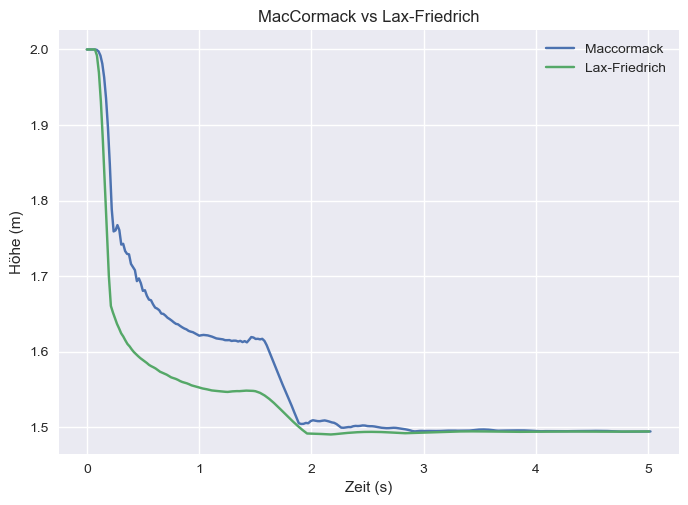

In [66]:
plt.style.use('seaborn')

# Vergleich der Lösungen
plt.plot(t2, v2, label='Maccormack')
plt.plot(t1, v1, label='Lax-Friedrich')
plt.title('MacCormack vs Lax-Friedrich')
plt.xlabel('Zeit (s)')
plt.ylabel('Höhe (m)')
plt.legend()
plt.show()